Data size before sanitisation, Total:  286
Removed, Rows with NA:  0
Total removal rows:  0


TypeError: HasTraits.observe() got an unexpected keyword argument 'weight1_multiplier'

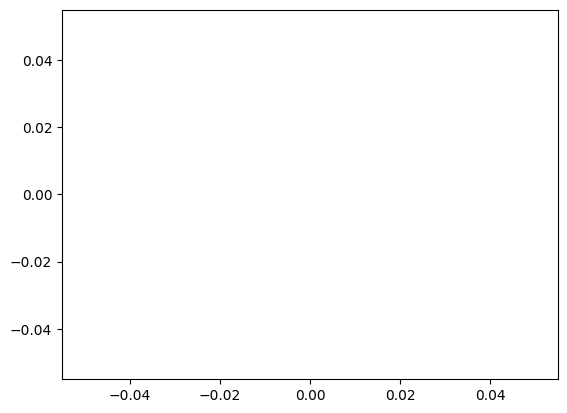

In [ ]:
from unittest.mock import inplace

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import re



######## Widgets for easy control ##########

from IPython.core.display_functions import display
import ipywidgets as widget
from ipywidgets import HBox, VBox

style = {'description_width': '150px',"button_width":"150px"}
layout = {'width': '400px'}
status_Widget = widget.HTML(
    placeholder='Status:',
    value= " Begin Training, then optionally display different outputs / internal data for diagnoses",
    layout=layout
)
training_rate_set = widget.FloatLogSlider(
    value=0.01,
    min=0.00,
    max=0.99,
    step=0.01,
    readout=True,
    description="Set learning rate weight multiplier",
    layout=layout,
    style=style,
)
weight1_multiplier_slider = widget.FloatLogSlider(
    value=1.0,
    min=0.01,
    max=2.50,
    step=0.01,
    readout=True,
    description="Initial Weight1 Cleation multiplier",
    layout=layout,
    style=style,
)
weight2_multiplier_slider = widget.FloatLogSlider(
    value=1.0,
    min=0.01,
    max=2.50,
    step=0.01,
    readout=True,
    description="Initial Weight2 Cleation multiplier",
    layout=layout,
    style=style,
)




######## Widgets for easy control ##########


%matplotlib inline
pd.set_option('future.no_silent_downcasting', True)
pd.options.mode.copy_on_write = True

data = pd.DataFrame( pd.read_excel('./breast-cancer.xls') )  # Data Import from local/ Drive file
original_data = data

global predictiontable, weight1, weight2

Log = widget.Output()

################# Data sanitisation #################
try: 
    total_rows = len(data)
    print("Data size before sanitisation, Total: ", total_rows)
    data.dropna(inplace=True) # Drops all NA cells by row and saves it back to source data
    print("Removed, Rows with NA: ", total_rows - len(data))
except:
    print()

def data_cleancing():  
    status_Widget.value += 'Began Data_Cleaning to format Data incoming' 
    try: 
        for x in data.index:

            if re.search( r"^[0-9]{1,2}-[0-9]{1,2}$",  str(data.loc[x, "age"]) ) is None and not ( re.search( r"^[0-9]{1,2}$",  str(data.loc[x, "age"])is None) ): #Using RegEx to confirm age pattern is not "XX-XX" / "X-XX" and not "XX"
                data.drop(index=x, inplace=True)
            elif re.search(r"^(ge40)$|^(premeno)$|^(lt40)$", str(data.loc[x, "menopause"])) is None:  #Using RegEx to confirm menopause name is only 1 of three
                data.drop(index=x, inplace=True)
            elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "tumor-size"]) ) is None:  #Using RegEx to confirm tumor size is formated correctly
                data.drop(index=x, inplace=True)
            elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "inv-nodes"])) is None: #Using RegEx to confirm node-caps is only yes or no Upper or lower case
                data.drop(index=x, inplace=True)
            elif re.match(r'^([Yy][eE][Ss]|[Nn][oO])$', str(data.loc[x, "node-caps"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x, inplace=True)
            elif re.search(r"^1$|^2$|^3$", str(data.loc[x, "deg-malig"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x, inplace=True)
            elif re.search(r"^([Ll][eE][fF][tT]|[Rr][Ii][Gg][hH][tT])$", str(data.loc[x, "breast"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x)
            elif re.search(r"^(left_up|left_low|central|right_up|right_low)$", str(data.loc[x, "breast-quad"]), re.IGNORECASE) is None:
                data.drop(index=x)#Using RegEx to confirm inv-nodes count is a number range

            #Force only standard answer for this query, Yes / Recurence will = Recurrence-event, anything with no / non = Non-recurrence-event
            elif re.search(r"(non|no|recurrence|Yes)", str(data.loc[x, "Class"]), re.IGNORECASE) is None:
                data.loc[x, "Class"] = "Non-recurrence-event"
            if re.search(r"(non|no)", str(data.loc[x, "Class"]), re.IGNORECASE) :
                data.loc[x, "Class"] = "Non-recurrence-event"
            else:
                data.loc[x, "Class"] = "Recurrence-event"
                data.drop(index=x)

        range_median('age')
        range_median('tumor-size')
        range_median('inv-nodes')
        numeric_Translation_Menopause = uniques_translator('menopause', False)
        numeric_Translation_NodeCaps = uniques_translator('node-caps', False)
        numeric_Translation_Breast = uniques_translator('breast', False)
        numeric_Translation_irradiat = uniques_translator('irradiat', False)
        numeric_Translation_Class = uniques_translator('Class', False)

        ##  Dictionary of the change to revert back later    ##

        ## Translating all string columns to int equivilant  ##

        uniques_translator('menopause', True)
        uniques_translator('node-caps', True)
        uniques_translator('breast-quad', True)
        uniques_translator('breast', True)
        uniques_translator('irradiat', True)
        uniques_translator('Class', True)
        ## Translating all string columns to int equivilant  ##
        
        
        ## Range medium finder for all non int only columns

        data = data[['age', 'menopause', 'tumor-size', 'inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat','Class']].apply(lambda e: (e - e.min()) / (e.max() - e.min()))

    except:
        status_Widget.value += 'Failed to complete database formatting'
data.reset_index(drop=True, inplace=True)  # Re indexes entire dataframe to fix deleted rows
print("Total removal rows: " , total_rows - len(data))
################# Data sanitisation #################

################# Data Formating #################
def range_median(column):
    status_Widget.value = 'Range Medium Run on Column: ' + column
    main_array = []
    for y in data.index:
        value = str(data.loc[y, column])
        if re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(value)) is not None:
            array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
            main_array.append(np.median(array))

        elif  re.search( r"^[0-9]{1,2}$",  value)is not None:
            array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
            main_array.append(np.median(array))
    data[str(column)] = main_array
    return main_array


def uniques_translator(column, inpalce_trigger):
    status_Widget.value = 'Uniques_Translation Run on Column: ' + column
    column_uniques = np.array(pd.unique(data[column]))
    translation_dictionary = {}
    for x in range(column_uniques.size):
        translation_dictionary.update({x : column_uniques[x]})
    if inpalce_trigger == True:
        data[str(column)] = data[[str(column)]].replace(column_uniques, translation_dictionary.keys())
        return data[[str(column)]]
    else:
        return data[[str(column)]].replace(column_uniques, translation_dictionary) , translation_dictionary

##  Dictionary of the change to revert back later    ##








################# Data Formating #################

################# Training Data Masking #################

def trainin_data_sets():
    try:


        training_data_per =  90/100.0

        data['train'] = np.random.rand(len(data)) < training_data_per # Creates random array for each row  of Data, true or false using the fraction
        Training_Data = data[data.train == 1] # Appends train Data with the array for each row, effectively showing which row at random will be removed

        Training_Data = Training_Data.drop('train', axis=1).sample(frac=1)
        ################# Training Data Masking #################

        ################# Testing Data Seperation / Masking #################
        Testing_Data = data[data.train == 0]
        Testing_Data.drop('train', axis=1, inplace=True)

        Training_Data = data[data.train == 1]
        Training_Data.drop('train', axis=1, inplace=True)
        #Using X to remove Class colum as Y will be the opposite, As it is the diagnoses column
        #Y = 0  1
        #    1  0
        #    1  0
        #    1  0
        #    0  1
        # == [0,0,0,1.....]
        X = Training_Data.drop('Class', axis=1).to_numpy(dtype=float)

        targets = [[1,0],[0,1]]
        Y = np.array([targets[int(z[0])]  for z in Training_Data.values[:,8:9]])
    except:
        status_Widget.value += 'Training_data_sets Creation failed' 
################# Testing Data Seperation / Masking #################

################# Backpropagating data creation #################

weight1_multiplier = 1
weight2_multiplier = 1
def propegation_creation():
    status_Widget.value += '     Began creation of propegation weights'
    try:
        NumberInput = len(X[0])
        Hidden_layer_Rows = 9
        rng = np.random.default_rng()

        weight1 = ( rng.uniform(-1, 1, (NumberInput, Hidden_layer_Rows)) - 1 ) * weight1_multiplier
        NumberOutputs = len(Y[0])
        weight2 = ( np.random.random((Hidden_layer_Rows, NumberOutputs)) - 1 ) * weight2_multiplier

        #Weight1 is [9 Columns]         and  [X length Rows]
        #Weight2 is [Y length Columns]  and  [ 4 Rows]
        # For Matrix Multiplication operation later
    except:
        status_Widget.value += '     Failed to create propegation Weights'


################# Backpropagating data creation #################

learning_rate = 0.01
error = []
def train():
    global weight1
    global weight2
    for epoch in range(5000):
        # X shape = 166, 9
        # weight1 = 9,9
        # weight2 = 9,2

        l1 = 1/(1 + np.exp(-(X @ weight1))) # shape (166, 9)

        l2 = 1/(1 + np.exp(-(l1 @ weight2))) # (166, 2)
        er = (abs(Y - l2)).mean()
        error.append(er)

        l2_delta = (Y - l2)*(l2 * (1-l2)) 
        weight2 += l1.T.dot(l2_delta) * learning_rate

        l1_delta = l2_delta.dot(weight2.T) * (l1 * (1-l1))
        weight1 += X.T.dot(l1_delta) * learning_rate
        

    #print(er)
#print("error" , error[-1])



# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

#fig = plt.figure(figsize=(5, 5))
#ax = fig.gca()
#ax.axis('off')
#draw_neural_net(ax, .1, .9, .1, .9, [9, 2, 1])

def testing():
    status_Widget.value += 'Testing Begun'
    global predictiontable
    try: 

        X_testing = pd.DataFrame(Testing_Data.drop('Class', axis=1).values.astype(float))   # shape (length, 9)

        Y_Testing = np.array([targets[int(r[0])]  for r in Testing_Data.values])

        l1 = 1/(1 + np.exp(-(X_testing @ weight1)))
        l2 = 1/(1 + np.exp(-(l1 @ weight2)))
        y_prediction = np.argmax(l2 , axis = 1)

        #print(Y_Prediction)
        resolution = y_prediction == np.argmax(Testing_Data['Class'], axis=0)
    


        correct = np.sum(resolution)/len(resolution)
        predictiontable = Testing_Data['Class'].replace([0,1], ['recurrence-events', 'no-recurrence-events']).to_frame().reset_index()
        predictiontable['prediction'] = pd.Series(resolution).replace([False,True], ['recurrence-events', 'no-recurrence-events'])
        predictiontable['Check'] = (pd.Series(y_prediction) != np.argmax(Y_Testing, axis=1))
        predictiontable['Raw_value_l2'] = y_prediction
        predictiontable['original_Raw_value'] = Testing_Data['Class'].reset_index().drop('index', axis=1)
        #print(l2[0])
        
        print('Correct:',sum(resolution),'/',len(resolution), ':', (correct*100),'%')
        return True
    
    except:  
        return False



Training_trigger_button = widget.Button(
    #on_click=train(),
    set=False,
    description="Begin Trianing",
    disable=False,
    style=style
)

Training_trigger_button = widget.Button(
    on_click=testing(),
    set=False,
    description="Begin Testing",
    disable=False,
    style=style
)
toggle_learning_graph_error = widget.ToggleButton(
    button_style='info',
    set=False,
    description="Toggle Error Plot Curve",
    disable=False,
    style=style,
    icon='check'
)

def observer(job)
    try:
        if job = "weight1_multiplier_slider":
            weight1_multiplier = weight1_multiplier_slider.value
    except:
        status_Widget.value += "      Failed to follow through with user input"



toggle_learning_graph_error.observe( plt.plot(error))
weight1_multiplier_slider.observe(observer('weight1_multiplier_slider'))
weight2_multiplier_slider.observe(observer('weight2_multiplier_slider'))
print(weight1_multiplier_slider.value)
display(HBox([Training_trigger_button,toggle_learning_graph_error ]), HBox([training_rate_set, status_Widget,toggle_learning_graph_error]))
